In [23]:
# This analysis is very similar to Vix analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC

In [2]:
# We do our initial tests with Bitcoin. We can expand this analysis later
coin_df = pd.read_csv('Data/coin_Bitcoin.csv')

coin_df.index = pd.to_datetime(coin_df['Date']).dt.date
coin_df.index = pd.DatetimeIndex(coin_df.index)

# Not useful
coin_df.drop('Date', axis=1, inplace=True)
coin_df.drop('SNo', axis=1, inplace=True)

coin_df.head()

,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,
2013-04-29,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [3]:
# Next we read in S&P 500 Dataset
sp_df = pd.read_csv('index_data/sp_500_historical.csv')
new_column_names = {
    "Close/Last": "Close"
}
sp_df.rename(columns=new_column_names, inplace=True)

sp_df.index = pd.to_datetime(sp_df['Date']).dt.date
sp_df.index = pd.DatetimeIndex(sp_df.index)

sp_df.drop('Date', axis=1, inplace=True)
# Drop Volume too. There are no non '--' values for Volume
sp_df.drop('Volume', axis=1, inplace=True)

sp_df.head()

,Close,Open,High,Low
Date,,,,
2021-03-29,3974.54,0.00,0.00,0.00
2021-03-26,3974.54,3917.12,3978.19,3917.12
2021-03-25,3909.52,3879.34,3919.54,3853.50
2021-03-24,3889.14,3919.93,3942.08,3889.07
2021-03-23,3910.52,3937.60,3949.13,3901.57


In [4]:
# The S&P 500 Dataframe appears to be backwards. Let's reverse it so that it is more in line with out coin set
# This probably doesn't matter, but just in case.
sp_df = sp_df.reindex(index=sp_df.index[::-1])
sp_df.head()

,Close,Open,High,Low
Date,,,,
2011-03-29,1319.44,1310.19,1319.45,1305.26
2011-03-30,1328.26,1319.44,1331.74,1321.89
2011-03-31,1325.83,1328.26,1329.77,1325.03
2011-04-01,1332.41,1325.83,1337.85,1328.89
2011-04-04,1332.87,1332.41,1336.74,1329.10


In [5]:
# We now need to preprocess our data some more. We need to make sure that the dates in our dataframes appear in both
coin_dates = set(coin_df.index)
sp_dates = set(sp_df.index)
shared_dates = sp_dates.intersection(coin_dates)

for date in sp_dates.difference(shared_dates):
    sp_df.drop(date, inplace=True)
for date in coin_dates.difference(shared_dates):
    coin_df.drop(date, inplace=True)

print(len(coin_df))
print(len(sp_df))

1996
1996


In [6]:
# Now let's make a new dataframe for coin return:
coin_return = pd.DataFrame(index=coin_df.index)
coin_return['coin_return'] = coin_df['Close'].pct_change()
sp_df['return'] = sp_df['Close'].pct_change()

# Now the first row will have a NaN value. So we drop it in both sp_df and coin_return
coin_return.drop(coin_return.index[0], inplace=True)
sp_df_copy = sp_df.drop(coin_return.index[0])

# Furthermore, the highs in the S&P 500 dataset are sometimes 0. We should get rid of those dates in both sets of data
zero_indeces = []
for index in sp_df_copy.index:
    if sp_df_copy.loc[index]['High'] == 0:
        zero_indeces += [index]

sp_df_copy.drop(zero_indeces, inplace=True)
coin_return.drop(zero_indeces, inplace=True)


Text(0, 0.5, 'Coin Return Percentage')

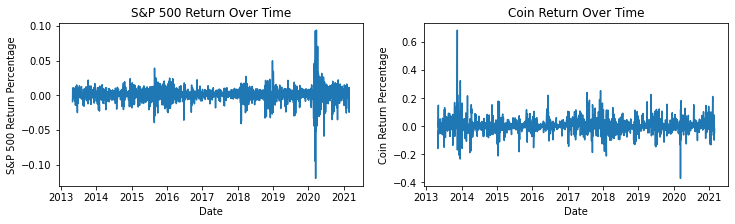

In [7]:
# Now let's do some basic data visualizations
fig = plt.figure(figsize=(12, 3))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(sp_df_copy.index, sp_df_copy['return'])
ax1.set_title('S&P 500 Return Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500 Return Percentage')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(coin_return.index, coin_return['coin_return'])
ax2.set_title('Coin Return Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Coin Return Percentage')

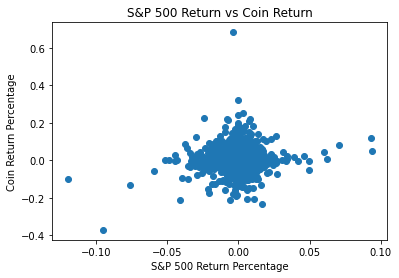

In [8]:
# Now let's try S&P 500 High vs Coin Return
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(sp_df_copy['return'], coin_return['coin_return'])
ax1.set_title("S&P 500 Return vs Coin Return")
ax1.set_xlabel("S&P 500 Return Percentage")
ax1.set_ylabel("Coin Return Percentage")
plt.show()

In [9]:
# We want to do a similar analysis as Vix-analysis. Our output is again sentiment
# > .2 then very good 0 < < 0.2 then good converse for bad and very bad
def get_sentiment(return_val):
    if return_val >= 0.2:
        return 'very good'
    elif return_val > 0 and return_val < 0.2:
        return 'good'
    elif return_val < 0 and return_val > -0.2:
        return 'bad'
    elif return_val <= 0.2:
        return 'very bad'
    else:
        return None
    
coin_sentiment = pd.DataFrame(index=coin_return.index)
coin_sentiment['sentiment'] = [get_sentiment(return_val) for return_val in coin_return['coin_return']]

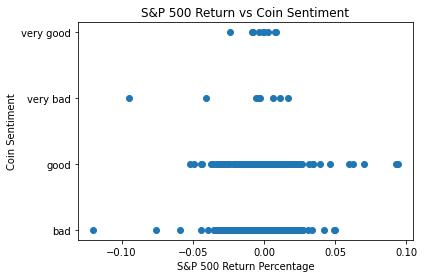

In [10]:
# Visualize this new data again
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(sp_df_copy['return'], coin_sentiment['sentiment'])
ax1.set_title("S&P 500 Return vs Coin Sentiment")
ax1.set_xlabel("S&P 500 Return Percentage")
ax1.set_ylabel("Coin Sentiment")
plt.show()

In [11]:
# Let's do our data split
X_train, X_test, Y_train, Y_test = train_test_split(sp_df_copy['High'], coin_sentiment['sentiment'], test_size=0.2, random_state=0)
X_train = np.array(X_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)


In [12]:
# An SVM looks to be useful here with the clustered data
model = SVC()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

In [13]:
accuracy_score(y_pred, Y_test)

0.549367088607595

In [14]:
# LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, Y_train)
y_pred = lr.predict(X_test)

In [15]:
accuracy_score(y_pred, Y_test)

0.5518987341772152

In [24]:
from sklearn.metrics import mean_squared_error
le = LabelEncoder() # Use the label encoder to transform our classes into numerical values
le.fit(Y_test)
mean_squared_error(le.transform(y_pred), le.transform(Y_test))

0.4481012658227848